# Exercício 3 - NLP

### Questão 1

Objetivo: prever se uma mensagem é spam ou não.

a) Qual porcentagem dos documentos são spam?

b) Usando mala de palavras (CountVectorizer), qual é o token mais longo do vocabulário dos dados de treinamento? Utilize o modelo de classificação multinomial Naive Bayes e encontre a (AUC) usando os dados de teste.

c) Utilize o vetorizador Tf-idf nos dados de treinamento. Quais 20 características têm o menor tf-idf e quais 20 têm o maior tf-idf? Coloque essas características em duas séries, onde cada série é classificada pelo valor tf-idf e, em seguida, em ordem alfabética pelo nome da característica. O índice da série deve ser o nome da característica e os dados devem ser o tf-idf. A série de 20 características com o menor tf-idfs deve ser classificada de forma crescente, a lista de 20 características com o maior tf-idfs deve ser classificada de forma decrescente.

d) Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 3. Use o modelo classificador multinomial Naive Bayes com alfa = 0.1, e então calcule a pontuação AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro alfa e descreva brevemente como esse parâmetro se comporta no modelo.

e) Qual é o tamanho médio dos documentos (número de caracteres) para documentos não-spam e documentos spam? Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5. Usando essa matriz de termos de documento e um característica  adicional (o comprimento do documento (número de caracteres)), treine um modelo SVC, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

f) Qual é o número médio de dígitos por documento para documentos não-spam e documentos spam? Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. Usando essa matriz de termos de documento e duas características  adicionais (o comprimento do documento e o número médio de dígitos por documento) treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

g) Qual é o número médio de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore) por documento para documentos não-spam e documentos spam? Dica: use as classes de caracteres \w e \W do pacote re (regular expressions). Utilize o vetorizador CountVectorizer nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. Usando esta matriz de termos de documento e as seguintes características adicionais: o comprimento do documento, número de dígitos por documento, e o número de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore), treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo. Encontre os 10 menores e os 10 maiores coeficientes do modelo e retorne-os juntamente com a pontuação da AUC em uma tupla. A lista dos 10 menores coeficientes deve ser classificada de forma crescente, a lista dos 10 maiores coeficientes de forma decrescente.

In [1]:
import pandas as pd
import numpy as np
import os
import re

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [15]:
# constants
DATA_DIR = 'CSV'
SPAM_FILE = 'spam.csv'

NOT_WORDS = 'not_words'
DIGITS = 'digits'

In [4]:
spam_data = pd.read_csv(os.path.join(DATA_DIR, SPAM_FILE))

spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
spam_data.head(10)

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1


## g) Qual é o número médio de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore) por documento para documentos não-spam e documentos spam? Dica: use as classes de caracteres \w e \W do pacote re (regular expressions). 

In [5]:
def non_word_chars(chunk):
    return re.findall('\W', chunk)

def not_words_stats(df, spam=1):
    return spam_data[spam_data.target == spam].loc[:,[NOT_WORDS]].describe().T

In [6]:
spam_data['not_words'] = spam_data.text.apply(lambda x: len(non_word_chars(x)))

In [7]:
spam_data.head()

,text,target,not_words
0,"Go until jurong point, crazy.. Available only ...",0,28
1,Ok lar... Joking wif u oni...,0,11
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,33
3,U dun say so early hor... U c already then say...,0,16
4,"Nah I don't think he goes to usf, he lives aro...",0,14


In [8]:
df = not_words_stats(spam_data, spam=1)
print('=> Média de caracteres que não são palavras, por documento, para documentos que são SPAM: {:.2f}'.format(
      df.loc[NOT_WORDS,'mean']))
df

=> Média de caracteres que não são palavras, por documento, para documentos que são SPAM: 29.04


,count,mean,std,min,25%,50%,75%,max
not_words,747.0,29.041499,7.319564,1.0,27.0,30.0,34.0,50.0


In [9]:
df = not_words_stats(spam_data, spam=0)
print('=> Média de caracteres que não são palavras, por documento, para documentos que NÃO são SPAM: {:.2f}'.format(
      df.loc[NOT_WORDS,'mean']))
df

=> Média de caracteres que não são palavras, por documento, para documentos que NÃO são SPAM: 17.29


,count,mean,std,min,25%,50%,75%,max
not_words,4825.0,17.291813,14.990677,0.0,8.0,13.0,22.0,253.0


## Utilize o vetorizador CountVectorizer nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. 

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], 
                                                    spam_data['target'], 
                                                    random_state=0)

In [11]:
# O padrão de token utilizado como "default" ignora termos com tamanho menor ou igual a 2 caracteres. 
# Alterei este padrão para ignorar os termos com menos de 5 caracteres.
token_pattern=r"(?u)\b\w\w\w\w\w+\b"
counter = CountVectorizer(stop_words='english', ngram_range=(1, 3), token_pattern=token_pattern)

In [14]:
train_matrix = counter.fit_transform(X_train)
train_matrix.shape

(4179, 22661)

## Usando esta matriz de termos de documento e as seguintes características adicionais: o comprimento do documento, número de dígitos por documento, e o número de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore), treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo. 

In [17]:
# returns the number of digits in a string (we'll use over documents)
def count_digits(chunk):
    return len(re.findall('\d', chunk))

In [18]:
spam_data[DIGITS] = spam_data.text.apply(count_digits)
spam_data.head()

,text,target,not_words,digits
0,"Go until jurong point, crazy.. Available only ...",0,28,0
1,Ok lar... Joking wif u oni...,0,11,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,33,25
3,U dun say so early hor... U c already then say...,0,16,0
4,"Nah I don't think he goes to usf, he lives aro...",0,14,0


In [19]:
# Transformação equivalente sobre os dados de teste para conseguirmos usar os mesmos tokens como features
test_matrix = counter.transform(X_test)
test_matrix.shape

(1393, 22661)

In [20]:
train_matrix

<4179x22661 sparse matrix of type '<class 'numpy.int64'>'
	with 37770 stored elements in Compressed Sparse Row format>

In [26]:
train_digits, test_digits = train_test_split(spam_data.digits, random_state=0)
train_not_words, test_not_words = train_test_split(spam_data.not_words, random_state=0)

In [36]:
train_digits.to_numpy().shape

(4179,)

In [43]:
ninja = np.array([7]*4179)[:, None]
ninja.shape

(4179, 1)

In [44]:
from scipy.sparse import hstack

# Vamos adicionar os valores de número de dígitos e número de caracteres que não são palavras à matriz 
# de ocorrência dos tokens (mala de palavras) para uso no modelo de regressão logística
train_features = hstack((train_matrix, train_digits.to_numpy()[:, None], train_not_words.to_numpy()[:, None]))
train_features.shape

(4179, 22663)

In [45]:
# A mesma coisa para os dados de teste
test_features = hstack((test_matrix, test_digits.to_numpy()[:, None], test_not_words.to_numpy()[:, None]))
test_features.shape

(1393, 22663)

In [48]:
from sklearn.linear_model import LogisticRegression

lrmodel = LogisticRegression(random_state=0, solver='liblinear', C=1.0)

In [49]:
lrmodel.fit(train_features, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
y_pred = lrmodel.predict(test_features)

In [51]:
# predict probabilities
lr_probs = lrmodel.predict_proba(test_features)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

In [53]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

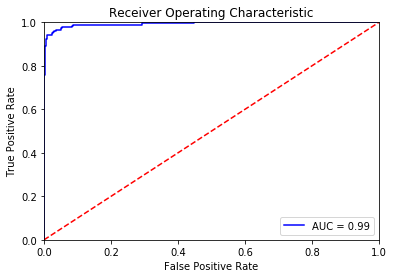

In [58]:
fpr, tpr, threshold = metrics.roc_curve(y_test, lr_probs)
roc_auc = metrics.roc_auc_score(y_test, lr_probs)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

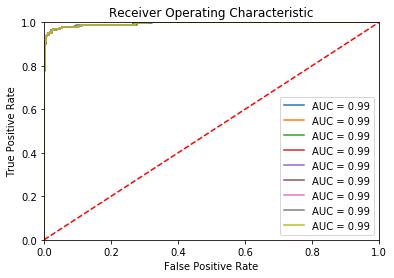

In [64]:
C_parameters = [3 * i for i in range(1, 10)]
models = [LogisticRegression(solver='liblinear', C=c_parameter) for c_parameter in C_parameters]

fpr_array = []
tpr_array  = []
for model in models:
    model.fit(train_features, y_train)
    probs = model.predict_proba(test_features)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    fpr_array.append(fpr)
    tpr_array.append(tpr)
    roc_auc = metrics.roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

--------------------------------------------

#### Colocar todos os caracteres em minúsculas para que as palavras possam ser comparadas com mais facilidade

In [14]:
spam_data.loc[:, ['text']] = spam_data.text.apply(lambda x: x.lower())
spam_data.head()

,text,target,not_words
0,"go until jurong point, crazy.. available only ...",0,28
1,ok lar... joking wif u oni...,0,11
2,free entry in 2 a wkly comp to win fa cup fina...,1,33
3,u dun say so early hor... u c already then say...,0,16
4,"nah i don't think he goes to usf, he lives aro...",0,14


## Encontre os 10 menores e os 10 maiores coeficientes do modelo e retorne-os juntamente com a pontuação da AUC em uma tupla. A lista dos 10 menores coeficientes deve ser classificada de forma crescente, a lista dos 10 maiores coeficientes de forma decrescente.

### Questão 2

Objetivo: Modelagem de Tópicos

a) Estimar os parâmetros do modelo LDA no corpus e salvar na variável ldamodel. Extrair 10 tópicos usando corpus e id_map, com os parâmetros 'passes' = 25 e 'random_state' = 35.

b) Usando ldamodel, encontre uma lista dos 10 tópicos e das 10 palavras mais significativas em cada tópico. Isso deve ser estruturado como uma lista de 10 tuplas.

c) Baseando-se na seguinte lista de tópicos, relacione com os tópicos encontrados pelo algoritmo gensim no corpus. A lista de tópicos pode ser estendida por vocês.

    Tópicos:
    Saúde, Ciência, Automóveis, Política, Governo, Viagem,
    Computadores e TI, Esportes, Negócios, Sociedade e
    Estilo de vida, Religião, Educação.

In [2]:
import pickle
import gensim
from sklearn.feature_extraction.text import CountVectorizer

with open('./CSV/newsgroups', 'rb') as f:
    newsgroup_data = pickle.load(f)

vect = CountVectorizer(min_df=20, max_df=0.2, stop_words='english', 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')
X = vect.fit_transform(newsgroup_data)

corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

id_map = dict((v, k) for k, v in vect.vocabulary_.items())

## a) Qual porcentagem dos documentos são spam?

In [5]:
spam_data.target.unique()

array([0, 1])

Os únicos valores presentes na série "target" são 0 e 1. Os documentos classificados como spam possuem valor 1 nesta série. Assim sendo, podemos obter o percentual de spam da base com uma simples soma e divisão

In [6]:
spam_ratio = spam_data.target.sum()/spam_data.target.size
print('=> O percentual de documentos que são spam é {0:.2f}%'.format(spam_ratio*100))

=> O percentual de documentos que são spam é 13.41%


In [7]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], 
                                                    spam_data['target'], 
                                                    random_state=0)

/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [12]:
X_train.head()

872                       I'll text you when I drop x off
831     Hi mate its RV did u hav a nice hol just a mes...
1273    network operator. The service is free. For T &...
3314    FREE MESSAGE Activate your 500 FREE Text Messa...
4929    Hi, the SEXYCHAT girls are waiting for you to ...
Name: text, dtype: object

In [18]:
y_train.head()

872     0
831     0
1273    1
3314    1
4929    1
Name: target, dtype: int64

## b) Usando mala de palavras (CountVectorizer), qual é o token mais longo do vocabulário dos dados de treinamento? Utilize o modelo de classificação multinomial Naive Bayes e encontre a (AUC) usando os dados de teste.


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

# Como assim token mais longo?????

In [24]:
counter = CountVectorizer()
occurrence_matrix = counter.fit_transform(X_train.values)

In [37]:
print(occurrence_matrix[0], occurrence_matrix.shape)

  (0, 3933)	1
  (0, 6421)	1
  (0, 7305)	1
  (0, 7085)	1
  (0, 2349)	1
  (0, 4624)	1 (4179, 7354)


In [38]:
mnb = MultinomialNB()
model = mnb.fit(occurrence_matrix.todense(), y_train.values)

In [42]:
test_occurrences = counter.fit_transform(X_test.values)

In [44]:
print(test_occurrences[0], test_occurrences.shape)

  (0, 442)	1
  (0, 3277)	1
  (0, 2042)	1
  (0, 2798)	1
  (0, 3718)	1
  (0, 964)	1
  (0, 3842)	1
  (0, 2130)	1
  (0, 3736)	1 (1393, 4170)


In [41]:
y_pred = model.predict(counter.fit_transform(X_test.values).todense())

ValueError: shapes (1393,4170) and (7354,2) not aligned: 4170 (dim 1) != 7354 (dim 0)